In [1]:
# %%writefile imports.py
import glob
import numpy as np
import pandas as pd

# standard system modules
import os, sys

# to plot pixelized images
import imageio.v3 as im

import warnings

# Suppress all RuntimeWarnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)
# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

import scipy.ndimage as ndi
from skimage.feature import peak_local_max
import matplotlib.colors as colors
from matplotlib import ticker

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN, HDBSCAN


### Load the data

In [2]:
# %%writefile load_data.py
def load_data(path):
    runs = sorted(glob.glob(os.path.join(path, '*.txt')))
    X = "ScintLeft"; Y = "AnodeBack"
    datalist = [pd.DataFrame(np.loadtxt(run, unpack = False), columns = [X,Y]) for run in runs]       
    return datalist


In [3]:
# def load_data(path):
#     runs = sorted(glob.glob(os.path.join(path, '*.txt')))
#     X = "ScintLeft"; Y = "AnodeBack"
#     datalist = [pd.DataFrame(np.loadtxt(run, unpack = False), columns = [X,Y]) for run in runs]       
#     return datalist

# SLABdat = load_data(path = './data/8kG/')
# # i = 0
# # smoothed_data = ndi.gaussian_filter((SLABdat[0][:,0],SLABdat[0][:,1]), sigma=0.1)  # adjust sigma for smoothness

# X = "ScintLeft"; Y = "AnodeBack"
# SL_min = 0; SL_max = 2000
# AB_min = 0 ; AB_max = 4000 

# # SLAB_full = pd.concat(SLABdat, axis = 0)
# SLAB_full = SLABdat[0]
# SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[X] <= SL_max) & (SLAB_full[Y] >= AB_min) & (SLAB_full[Y] <= AB_max)]
# SLAB = SLAB.reset_index(drop=True)# pandas keeps the indices of the original, we want to reset to avoid any future issues

# # Rescales data to better interpret and get better cluster results
# scaler = StandardScaler()
# scaled_data = pd.DataFrame(scaler.fit_transform(SLAB[[X, Y]]), columns = [X,Y])
# # print(SLAB)
# # SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[Y] >= AB_min)]

## Plan for the analysis
1. Resample the data set using the density_aware_resample() function. The resampled set will be used for the HDBSCAN.
2. Run the gp_minimize() function with the resampled data to determine what are the best parameters to use in HDBSCAN.
3. Put those results into the HDBSCAN function and check whether the clusters are identified well.
4. Get centroid positions and assign particle groups based on their position relative to each other.
5. Make a set of lines that surround a group of interest to be gated on.

### Resample the data so that DBSCAN doesn't take forever

In [4]:
# %%writefile density_aware_resample.py
from sklearn.neighbors import NearestNeighbors


def density_aware_resample(data, n_samples, n_subsets, k):
    """
    Resample the dataset in a density-aware manner.
    
    Parameters:
    - data: ndarray, the full dataset (shape: [n_samples, n_features])
    - n_samples: int, number of points per subset
    - n_subsets: int, number of subsets to create
    - k: int, number of nearest neighbors for density estimation

    Returns:
    - subsets: list of ndarray, resampled subsets
    """
    
    # Estimate local density using k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(data) # Returns indices of and distances to the neighbors of each point.
    local_density = 1 / (np.mean(distances, axis=1) + 1e-10)  # Avoid divide-by-zero
    
    # Invert densities to give higher weights to sparse regions
    # weights = 1 / (local_density + 1e-10)
    # max_weight = np.percentile(weights, 95)  # Use the 95th percentile as a threshold
    # weights = np.minimum(weights, max_weight)
    # Blend density-aware and uniform sampling
    density_weights = 1 / (local_density + 1e-10)
    density_weights /= np.sum(density_weights)  # Normalize density-based weights
    
    uniform_weights = np.ones_like(density_weights) / len(density_weights)  # Uniform weights
    alpha = 0.5  # Weight for density-aware sampling
    weights = alpha * density_weights + (1 - alpha) * uniform_weights
    weights /= np.sum(weights)  # Normalize combined weights
    # weights /= np.sum(weights)  # Normalize weights
    scaler = StandardScaler()
    
    # Generate subsets
    subsets_scaled = []; subsets_unscaled = []
    for _ in range(n_subsets):
        sampled_indices = np.random.choice(len(data), size=n_samples, p=weights)
        subsets_scaled.append(pd.DataFrame(scaler.fit_transform(data.iloc[sampled_indices]), columns = ['ScintLeft', 'AnodeBack']))
        subsets_unscaled.append(pd.DataFrame(scaler.inverse_transform(subsets_scaled[_]), columns = ['ScintLeft', 'AnodeBack']))
    return subsets_scaled, subsets_unscaled
   



In [5]:
# # X_sampled = pd.DataFrame(scaler.fit_transform(SLAB.iloc[0:10000]), columns = [X,Y])
# # Assuming `data` is your dataset as a NumPy array
# # data = SLAB
# n_subsets = 1
# sample_k = 5
# n_samples_per_subset = 2000#int(0.005 * len(data)) # 1% of the dataset
# print(n_samples_per_subset)

# if len(SLAB) > 3000:
#     subsets, subsets_unscaled = density_aware_resample(SLAB, n_samples=n_samples_per_subset, n_subsets=n_subsets, k = sample_k)
#     plot_subsets(data = SLAB,subsets =subsets_unscaled, magfield =8, angle = 35)
#     data = pd.DataFrame(subsets_unscaled[0], columns = [X,Y])
    
# else:
#     plt.figure()
#     plt.hist2d(SLAB[X], SLAB[Y], bins = [256,256], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
#     plt.xlabel('Rest Energy [arb. units]')
#     plt.ylabel('Energy Loss [arb. units]')
#     plt.annotate(f'Total counts: {len(SLAB['ScintLeft'])}', fontsize = 9, xy = [1200,2000])
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
#     ax.xaxis.set_minor_locator(ticker.MaxNLocator(20))
#     ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
#     ax.yaxis.set_minor_locator(ticker.MaxNLocator(30))
#     plt.subplots_adjust(wspace = 0.0)
#     # plt.savefig('Resampleddata.png'n)



### Try DBSCAN on a subset

In [6]:
from skopt import gp_minimize

# data = pd.DataFrame(subsets_unscaled, columns = [X,Y])
# https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html
def clustering_score(params):
    min_samples, min_cluster_size = params
    db = HDBSCAN(min_samples=int(min_samples), min_cluster_size=int(min_cluster_size))
    clusterer = db.fit(data)
    labels = clusterer.labels_
    # penalize degenerate clustering 
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1 and n_clusters < 5:  # Between 2 to 4 clusters            
        return 1.0 - np.mean(clusterer.probabilities_)
    return 1.0  # Penalize bad clustering

# prange = [(15, 40),  # min_samples
#           (20, 70)]  # min_cluster_size

# result = gp_minimize(clustering_score, prange, n_calls=50, random_state=42)
# print(f"Best parameters for HDBSCAN: \n min_samples: {result.x[0]} \n min_cluster_size: {result.x[1]}")

In [7]:
from sklearn.utils import resample
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import HDBSCAN

# X_sampled = data

# db = HDBSCAN(min_samples = result.x[0], min_cluster_size = result.x[1]).fit(X_sampled)
# labels = db.labels_
# # centroids = db.centroids_
# # SLAB_label = pd.concat((SLAB,labels), axis = 1)
# # print(len(scaled_data))




# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print(n_clusters_)

# # Plot result

# # Getting cluster centroids
# unique_labels = np.unique(labels[labels >= 0])  # Exclude noise (-1)
# centroids = pd.DataFrame(np.array([X_sampled[labels == label].mean(axis=0) for label in unique_labels]), columns = ['Xpos', 'Ypos'])

# plt.figure()
# plt.scatter(X_sampled[X], X_sampled[Y], marker = '.', c = db.labels_)
# plt.scatter(centroids['Xpos'], centroids['Ypos'], color = 'red', marker = 'x')
# # plt.scatter(scaled_data[X], scaled_data[Y], marker = '.', c = db.labels_)


Assigning groups to particles

In [8]:
# %%writefile get_particle_class.py
def get_particle_class(centroids):
    
    # initialize a new column to put labels in later
    centroids['Particle Label'] = None
    
    # initialize arrays for for loop
    Xrel_positions = np.zeros((len(centroids), len(centroids)))
    Yrel_positions = np.zeros((len(centroids), len(centroids)))
    Xpos = centroids['Xpos']
    Ypos = centroids['Ypos']
    
    for i in range(len(centroids)):
        for j in range(len(centroids)):
            # build matrices that hold the relative distances to each group
            Xrel_positions[i, j] = Xpos[j] - Xpos[i]  # X-axis difference
            Yrel_positions[i, j] = Ypos[j] - Ypos[i]  # Y-axis difference 
    
            # Set conditions that need to be met to be classified as a proton
            Proton_conditions = (
                (sum(Xrel_positions[i,:] < 0) >= len(centroids)-1 and # Protons are the lowest-right (highest x-position, lowest y-position)
                Ypos[i] < 1100 and
                sum(Yrel_positions[i,:] > 0) >= len(centroids)-1) or
    
                sum(Xrel_positions[i,:] == -np.max(Xrel_positions)) == 1 # It is usually the furthest group, others are bunched up
            )
    
            # Set conditions that need to be met to be classified as an alpha particle
            Alpha_conditions = ( 
                sum(Yrel_positions[i,:] < 0) == len(centroids)-1 and # Highest point and usually in the corner
                Xpos[i] < 800 and 
                Ypos[i] > 1000
                
            )
            # Set conditions that need to be met to be classified as a triton
            Triton_conditions = (
                (centroids['Particle Label'][j] == "Alphas" and # It is below alphas if alphas are defined
                Yrel_positions[i,j] > 0 and            
                centroids['Particle Label'][j] == "Deuterons" and  # It is above deuterons if deuterons are defined
                Xrel_positions[i,j] > 0 and Yrel_positions[i,j] < 0) or
    
                (len(centroids) == 4 and  # If there are 4 clusters, then it is the 2nd highest in the y
                sum(Yrel_positions[i,:] < 0) >= 2 and
                sum(Yrel_positions[i,:] > 0) >= 1 and
                sum(Xrel_positions[i,:] > 0) >= len(centroids)-1) or # it is usually the left-most group (need to confirm)
    
                # If there are 3 groups and the proton group is not included
                (len(centroids) == 3 and
                sum(Yrel_positions[i,:] < 0) >= 1 and
                sum(Yrel_positions[i,:] > 0) >= 1 and
                sum(Xrel_positions[i,:] > 0) >= len(centroids)-1)        
            )
            
            # Set conditions that need to be met to be classified as a deuteron
            Deuteron_conditions = (
                
                (centroids['Particle Label'][j] == "Alphas" and # It is below alphas if they are defined
                Yrel_positions[i,j] > 0 and            
                centroids['Particle Label'][j] == "Tritons" and  # It is below and to the right of tritons if they are defined
                Xrel_positions[i,j] < 0 and
                Yrel_positions[i,j] > 0 and
                centroids['Particle Label'][j] == "Protons" and  # It is above and to the left of protons if they are defined
                Xrel_positions[i,j] > 0 and
                Yrel_positions[i,j] < 0) or
    
                # If there are three groups and tritons or alphas are missing
                (len(centroids) == 3 and
                sum(Yrel_positions[i,:] < 0) >= 1 and # it becomes the middle group
                sum(Yrel_positions[i,:] > 0) >= 1) or
                
                # If there are three groups and the protons are missing
                (len(centroids) == 3 and
                sum(Yrel_positions[i,:] < 0) >= 2 and
                sum(Xrel_positions[i,:] < 0) >= 2) or
    
                # If there are four groups, it is the 2nd farthest to the right
                (len(centroids) == 4 and  
                sum(Xrel_positions[i,:] < 0) >= 2 and
                sum(Xrel_positions[i,:] > 0) >= 1 and
                sum(Yrel_positions[i,:] > 0) >= 2 and
                sum(Yrel_positions[i,:] < 0) >= 1) 
                
            )
            
            if Proton_conditions:
                centroids.loc[i,'Particle Label'] = "Protons"
            
            if Alpha_conditions:
                centroids.loc[i,'Particle Label'] = "Alphas"
    
            if Triton_conditions:
                centroids.loc[i,'Particle Label'] = "Tritons"
    
            if Deuteron_conditions:
                centroids.loc[i,'Particle Label'] = "Deuterons"
    
            # If no particles are detected, label group as 'Not a Particle'. 
            # Can be a good backup in case the clustering doesn't work well.
    # if Proton_conditions and Alpha_conditions and Triton_conditions and Deuteron_conditions:
    #     None
    # else:
    #     centroids.loc[i,'Particle Label'] = "Not a particle group"
                
    return centroids
    
# particles = get_particle_class(centroids)
# print("Relative Positions (i, j, [dy, dx]):\n", Yrel_positions)
# print(particles)


In [51]:
# %%writefile clusterplots.py
from matplotlib.ticker import AutoMinorLocator
from scipy.spatial import ConvexHull

def plot_subsets(data, subsets, magfield, angle, figsize=(12, 12)):
    """
    Plot subsets in a grid of subplots.
    
    Parameters:
    - data: Data to be plotted
        type: pandas Dataframe
    - subsets: list of ndarray, the subsets to plot
        type: list
    -magfield: Magnetic field setting of the SE-SPS
        type: float
    - angle: The angle at which the SE-SPS is set to.
        type: float
    - figsize: size of the figure
        type: float
    
    Returns:
    - None
    """
    SLAB = data
    n_subsets = len(subsets)

    if n_subsets > 1:
        cols = 3  # Number of columns in the subplot grid
        rows = (n_subsets + cols - 1) // cols  # Calculate rows needed
    
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle(f'Magnetic field: {magfield} kG ; Angle: {angle} degrees')
        axes = axes.flatten()  # Flatten in case of extra empty axes
        
        for i, subset in enumerate(subsets):
            ax = axes[i]
            ax.scatter(subset['ScintLeft'], subset['AnodeBack'], s=10, marker = '.', alpha=0.7)
            # ax.set_title(f"Subset {i+1}")
            # ax.set_xlabel("Feature 1")
            # ax.set_ylabel("Feature 2")
    
        # Hide extra axes
        for j in range(len(subsets), len(axes)):
            axes[j].axis('off')
    
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1,2, figsize = (8,4), sharey = True)
        fig.suptitle(f'Magnetic field: {magfield} kG ; Angle: {angle} degrees')
        ax[0].hist2d(SLAB['ScintLeft'], SLAB['AnodeBack'], bins = [512,512], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
        ax[0].set_xlabel('Rest Energy [arb. units]', fontsize  = 13)
        ax[0].set_ylabel('Energy Loss [arb. units]', fontsize  = 13)
        ax[0].set_title('Original Data', fontsize  = 13)
        ax[0].tick_params(direction = 'in', which = 'both', top =True, right = True)
        ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax[0].xaxis.set_minor_locator(ticker.MaxNLocator(20))
        ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax[0].yaxis.set_minor_locator(ticker.MaxNLocator(30))
        ax[0].annotate(f'Total counts: {len(SLAB['ScintLeft'])}', fontsize = 9, xy = [1100,2000])
        
        ax[1].hist2d(subsets[0]['ScintLeft'], subsets[0]['AnodeBack'], bins = [512,512], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
        ax[1].tick_params(direction = 'in', which = 'both', top =True, right = True)
        ax[1].set_xlabel('Rest Energy [arb. units]', fontsize  = 13)
        # ax[1].set_ylabel('Energy Loss [arb. units]')
        ax[1].set_title('Resampled data', fontsize  = 13)
        ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax[1].xaxis.set_minor_locator(ticker.MaxNLocator(20))
        ax[1].annotate(f'Total counts: {len(subsets[0]['ScintLeft'])}', fontsize = 9, xy = [1200,2000])
        plt.subplots_adjust(wspace = 0.0)
        # plt.savefig('Resampleddata.png')
        # plt.tight_layout()
        # plt.savefig('Resampleddata.png')
        plt.show()
        
        
def ParticleGate(particle_pd):
    """
    Finds the particle group of interest, calculates the Convex hull,
    and extracts vertices of the particle group.
    
    Parameters:
    - particle_pd: Dataframe of data points corresponding to a cluster group.
        type: pandas DataFrame
    
    Returns:
    - cluster_points: The data points of the group of interest.
        type: pandas DataFrame
    - vertices: The vertices of the group of interest.
        type: pandas DataFrame
    """
    # Filter points for the cluster of interest 
    cluster_points = particle_pd
    
    # Calculate the convex hull
    hull = ConvexHull(cluster_points)
    
    # Extract vertices
    vertices = cluster_points.iloc[hull.vertices]
    # Add first vertex back to close the gate
    vertices = pd.concat([vertices, vertices.iloc[[0]]])
    
    return cluster_points, vertices
     
def plot_particles(labels, particles, centroids, data):
    
    """
    Plots all of the particles identified by the algorithm and the associated 
    gates constructed using ParticleGate().
    
    Parameters:
    - labels: A list of labels associated to datapoints in data.
        type: ndarray
    - particles: Dataframe containing centroid positions and associated particle label.
        type: pandas DataFrame
    - centroids: The centroids of the clusters.
        type: pandas DataFrame
    - data: The full data set used in clustering.
        type: pandas DataFrame
    
    Returns:
    - None
    """
    allparts = []; alllabels = [] ; gates = []
    X = "ScintLeft"; Y = "AnodeBack"
    plt.figure()
    
    if particles['Particle Label'].str.contains(f'Protons').any():
        Proton_label = centroids.loc[centroids['Particle Label'] == 'Protons'].index[0]
        Protons = data[labels == Proton_label]
        ProtonGate = ParticleGate(Protons)
        plt.scatter(Protons[X], Protons[Y], marker = '.', color = 'purple', label = 'Protons')
        plt.plot(ProtonGate[1][X], ProtonGate[1][Y], 'r--', lw=2)
        allparts.append(Protons)
        alllabels.append('Protons')
        gates.append(ProtonGate)
        # return ProtonGate
        
    if particles['Particle Label'].str.contains('Tritons').any():
        Triton_label = centroids.loc[centroids['Particle Label'] == 'Tritons'].index[0]
        Tritons = data[labels == Triton_label]
        TritonGate = ParticleGate(Tritons)
        plt.scatter(Tritons[X], Tritons[Y],  marker = '.', label = 'Tritons')
        plt.plot(TritonGate[1][X], TritonGate[1][Y], 'r--', lw=2)
        allparts.append(Tritons)
        alllabels.append('Tritons')
        gates.append(TritonGate)
        # return TritonGate
    
    if particles['Particle Label'].str.contains('Deuterons').any():
        Deuteron_label = centroids.loc[centroids['Particle Label'] == 'Deuterons'].index[0]
        Deuterons = data[labels == Deuteron_label]
        DeuteronGate =ParticleGate(Deuterons)
        plt.scatter(Deuterons[X], Deuterons[Y],  marker = '.', label = 'Deuterons')
        plt.plot(DeuteronGate[1][X], DeuteronGate[1][Y], 'r--', lw=2)
        allparts.append(Deuterons)
        alllabels.append('Deuterons')
        gates.append(DeuteronGate)
        # return DeuteronGate
    
    if particles['Particle Label'].str.contains('Alphas').any():
        Alpha_label = centroids.loc[centroids['Particle Label'] == 'Alphas'].index[0]
        Alphas = data[labels == Alpha_label]
        AlphaGate = ParticleGate(Alphas)
        plt.scatter(Alphas[X], Alphas[Y],  marker = '.', label = 'Alphas')
        plt.plot(AlphaGate[1][X], AlphaGate[1][Y], 'r--', lw=2)
        allparts.append(Alphas)
        alllabels.append('Alphas')
        gates.append(AlphaGate)
        # return AlphaGate
    
    
    Outliers = data[labels == -1]
    plt.scatter(Outliers[X], Outliers[Y], color = 'grey', marker = '.', label = 'Outliers')
    plt.xlabel('Rest Energy [arb. units]')
    plt.ylabel('Energy Loss [arb. units]')
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(direction = 'in', which = 'both', top =True, right = True)
    plt.legend(loc = 'upper right')
    # plt.show()
    return allparts, alllabels, gates

def plot_particle_of_interest(labels, particles, centroids, data, particle_of_interest):
    
    """
    Plots the particle of interest and its associated gate 
    constructed using ParticleGate().
    
    Parameters:
    - labels: A list of labels associated to datapoints in data.
        type: ndarray
    - particles: Dataframe containing centroid positions and associated particle label.
        type: pandas DataFrame
    - centroids: The centroids of the clusters.
        type: pandas DataFrame
    - data: The full data set used in clustering.
        type: pandas DataFrame
    - particle_of_interest: The particle you want to gate on.
        type: string
    
    Returns:
    - None
    """
    allparts = []; alllabels = []
    X = "ScintLeft"; Y = "AnodeBack"
    if particle_of_interest == 'Proton':
        if particles['Particle Label'].str.contains(f'Protons').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Proton_label = centroids.loc[centroids['Particle Label'] == 'Protons'].index[0]
            Protons = data[labels == Proton_label]
            ProtonGate = ParticleGate(Protons)
            plt.scatter(Protons[X], Protons[Y], marker = '.', color = 'purple', label = 'Protons')
            plt.plot(ProtonGate[1][X], ProtonGate[1][Y], 'r--', lw=2)
            Outlierplot(data, labels)
            allparts.append(Protons)
            alllabels.append('Protons')
            # return ProtonGate
        else:
            print('There are no protons!')
        
    if particle_of_interest == 'Triton':
        if particles['Particle Label'].str.contains(f'Tritons').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Triton_label = centroids.loc[centroids['Particle Label'] == 'Tritons'].index[0]
            Tritons = data[labels == Triton_label]
            TritonGate = ParticleGate(Tritons)
            plt.scatter(Tritons[X], Tritons[Y],  marker = '.', label = 'Tritons')
            plt.plot(TritonGate[1][X], TritonGate[1][Y], 'r--', lw=2)
            Outlierplot(data, labels)
            allparts.append(Tritons)
            alllabels.append('Tritons')
            # return TritonGate
        else:
            print('There are no tritons!')
    
    if particle_of_interest == 'Deuteron':
        if particles['Particle Label'].str.contains(f'Deuterons').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Deuteron_label = centroids.loc[centroids['Particle Label'] == 'Deuterons'].index[0]
            Deuterons = data[labels == Deuteron_label]
            DeuteronGate =ParticleGate(Deuterons)
            plt.scatter(Deuterons[X], Deuterons[Y],  marker = '.', label = 'Deuterons')
            plt.plot(DeuteronGate[1][X], DeuteronGate[1][Y], 'r--', lw=2)
            Outlierplot(data, labels)
            allparts.append(Deuteron)
            alllabels.append('Deuterons')
            
        else:
            print('There are no Deuterons!')
    
    if particle_of_interest == 'Alpha':
        if particles['Particle Label'].str.contains(f'Alphas').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Alpha_label = centroids.loc[centroids['Particle Label'] == 'Alphas'].index[0]
            Alphas = data[labels == Alpha_label]
            AlphaGate = ParticleGate(Alphas)
            plt.scatter(Alphas[X], Alphas[Y],  marker = '.', label = 'Alphas')
            plt.plot(AlphaGate[1][X], AlphaGate[1][Y], 'r--', lw=2)
            Outlierplot(data, labels)
            allparts.append(Alphas)
            alllabels.append('Alphas')
            # return AlphaGate
        else:
            print('There are no alphas!')
    
    
def Outlierplot(data, labels):    
    X = "ScintLeft"; Y = "AnodeBack"
    Outliers = data[labels == -1]
    plt.scatter(Outliers[X], Outliers[Y], color = 'grey', marker = '.', label = 'Outliers')
    plt.xlabel('Rest Energy [arb. units]')
    plt.ylabel('Energy Loss [arb. units]')
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(direction = 'in', which = 'both', top =True, right = True)
    plt.legend(loc = 'upper right')
    plt.show()

def plot_gate_fulldata(labels, particles, centroids, data, full_data, particle_of_interest):
    
    X = "ScintLeft"; Y = "AnodeBack"    
    if particle_of_interest == 'Proton':
        if particles['Particle Label'].str.contains(f'Protons').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Proton_label = centroids.loc[centroids['Particle Label'] == 'Protons'].index[0]
            Protons = data[labels == Proton_label]
            ProtonGate = ParticleGate(Protons)
            plt.hist2d(full_data[X], full_data[Y], bins = [512,512], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
            # plt.scatter(full_data[X], full_data[Y], marker = '.', color = 'purple', label = 'Protons')
            plt.plot(ProtonGate[1][X], ProtonGate[1][Y], 'r--', lw=2)
            plt.show()
            # Outlierplot(data, labels)
            # return ProtonGate
        else:
            print('There are no protons!')
        
    if particle_of_interest == 'Triton':
        if particles['Particle Label'].str.contains(f'Tritons').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Triton_label = centroids.loc[centroids['Particle Label'] == 'Tritons'].index[0]
            Tritons = data[labels == Triton_label]
            TritonGate = ParticleGate(Tritons)
            plt.hist2d(full_data[X], full_data[Y], bins = [512,512], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
            # plt.scatter(full_data[X], full_data[Y],  marker = '.', label = 'Tritons')
            plt.plot(TritonGate[1][X], TritonGate[1][Y], 'r--', lw=2)
            plt.show()
            # Outlierplot(data, labels)
            # return TritonGate
        else:
            print('There are no tritons!')
    
    if particle_of_interest == 'Deuteron':
        if particles['Particle Label'].str.contains(f'Deuterons').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Deuteron_label = centroids.loc[centroids['Particle Label'] == 'Deuterons'].index[0]
            Deuterons = data[labels == Deuteron_label]
            DeuteronGate =ParticleGate(Deuterons)
            plt.hist2d(full_data[X], full_data[Y], bins = [512,512], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
            # plt.scatter(full_data[X], full_data[Y],  marker = '.', label = 'Deuterons')
            plt.plot(DeuteronGate[1][X], DeuteronGate[1][Y], 'r--', lw=2)
            plt.show()
            # # Outlierplot(data, labels)
            # return DeuteronGate
        else:
            print('There are no Deuterons!')
    
    if particle_of_interest == 'Alpha':
        if particles['Particle Label'].str.contains(f'Alphas').any():
            plt.figure()
            plt.title(f'{particle_of_interest} Gate')
            Alpha_label = centroids.loc[centroids['Particle Label'] == 'Alphas'].index[0]
            Alphas = data[labels == Alpha_label]
            AlphaGate = ParticleGate(Alphas)
            plt.hist2d(full_data[X], full_data[Y], bins = [512,512], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
            plt.plot(AlphaGate[1][X], AlphaGate[1][Y], 'r--', lw=2)
            plt.show()
            # Outlierplot(data, labels)
            # return AlphaGate
        else:
            print('There are no alphas!')

In [113]:
%%writefile PIDClassifier.py
# import time

def PIDClassifier(particle_of_interest, 
                  magfield: float, 
                  angle: float, 
                  datapath, 
                  n_subset_samples,
                  k_NearestNeighbors,
                  prange = [(15, 40),(20, 70)],
                  outputpath = './',
                  resample = True,
                  multfiles = False,
                  savefile = False):
    """
    Run entirety of Clustering algorithm to identify and classify
    clusters from PID plots.
    
    Parameters:
    - particle_of_interest: the particle you want to gate on for analysis
        type: string
        options: 'Proton', 'Triton', 'Deuteron', 'Alpha'
        
    - magfield: The magnetic field setting of the SPS in kG
        type: float
        
    - angle: The angle at which the SE-SPS is set at.
        type: float
        
    - datapath: Path to PID data files
        type: string
        
    - n_subset_samples: The number of resampled datasets to create, default is 1.
        type: int
        comments: Currently, the algorithm only takes one.
        
    - k_NearestNeighborhoods: Number of neighbors to use by default for kneighbors queries used in density_aware_resample function.
        type: int

    - prange: The range for min_samples and min_cluster_size parameters for HDBSCAN
        type: list of ints with shape (2,2)

    - outputpath: The path for the outputted file containing the gate's vertices to be put.
        type: string

    - resample: Gives the option to resample data for more efficiency.
        type: boolean
        options: True, False

    - savefile: Determines whether the gate's vertices will be outputed to a txt file.
        type: boolean
        options: True, False
        
    Returns:
    - None if savefile = False
    - Particle gate vertices if savefile = True
    
    """
    # time.sleep(2)
    SLABdat = load_data(path = datapath)
    
    X = "ScintLeft"; Y = "AnodeBack"
    SL_min = 0; SL_max = 2000
    AB_min = 0 ; AB_max = 4000 
    
    if multfiles == True:
        SLAB_full = pd.concat(SLABdat, axis = 0)
    else:
        SLAB_full = SLABdat[0]
        
    # SLAB_full = SLABdat[0]
    SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[X] <= SL_max) & (SLAB_full[Y] >= AB_min) & (SLAB_full[Y] <= AB_max)]
    SLAB = SLAB.reset_index(drop=True)# pandas keeps the indices of the original, we want to reset to avoid any future issues
    
    if resample == True:
    # 
    #                           Resampling section
    #
    
        n_subsets = 1
        sample_k = k_NearestNeighbors 
        n_samples_per_subset = n_subset_samples
        # print(n_samples_per_subset)
        
        if len(SLAB) > 3000:
            subsets, subsets_unscaled = density_aware_resample(SLAB, n_samples=n_samples_per_subset, n_subsets=n_subsets, k = sample_k)
            plot_subsets(SLAB, subsets_unscaled, magfield, angle)
            data = pd.DataFrame(subsets_unscaled[0], columns = [X,Y])
            print('Using the resampled data, check plot if it is admissable.')
        else:
            print('Too small to resample')
            plt.figure()
            plt.hist2d(SLAB[X], SLAB[Y], bins = [256,256], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
            plt.xlabel('Rest Energy [arb. units]')
            plt.ylabel('Energy Loss [arb. units]')
            plt.annotate(f'Total counts: {len(SLAB['ScintLeft'])}', fontsize = 9, xy = [1200,2000])
            ax = plt.gca()
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
            ax.xaxis.set_minor_locator(ticker.MaxNLocator(20))
            ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
            ax.yaxis.set_minor_locator(ticker.MaxNLocator(30))
            data = SLAB
    else:
        data = SLAB
        plt.figure()
        plt.hist2d(SLAB[X], SLAB[Y], bins = [256,256], range = [[0,2000],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
        plt.xlabel('Rest Energy [arb. units]')
        plt.ylabel('Energy Loss [arb. units]')
        plt.annotate(f'Total counts: {len(SLAB['ScintLeft'])}', fontsize = 9, xy = [1200,2000])
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax.xaxis.set_minor_locator(ticker.MaxNLocator(20))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax.yaxis.set_minor_locator(ticker.MaxNLocator(30))
    

    #
    #         Optimizing hyperparameters for HDBSCAN
    #
    #   prange = [(15, 40),  # min_samples
    #           (20, 70)]  # min_cluster_size
    def clustering_score(params):
        min_samples, min_cluster_size = params
        db = HDBSCAN(min_samples=int(min_samples), min_cluster_size=int(min_cluster_size))
        clusterer = db.fit(data)
        labels = clusterer.labels_
        # penalize degenerate clustering 
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1 and n_clusters < 5:  # Between 2 to 4 clusters            
            return 1.0 - np.mean(clusterer.probabilities_)
        return 1.0  # Penalize bad clustering
    
    print('Optimizing hyperparameters for HDBSCAN...')
    result = gp_minimize( clustering_score, prange, n_calls=50, random_state=42)
    print(f"Optimization complete! \n Best parameters for HDBSCAN: \n min_samples: {result.x[0]} \n min_cluster_size: {result.x[1]}")
    
    #
    #           Performing HDBSCAN clusteering algortihm
    # - Provides cluster labels and gets cluster centroid locations
    #
    print('Performing HDBSCAN clustering algorithm...')
    db = HDBSCAN(min_samples = result.x[0], min_cluster_size = result.x[1]).fit(data)
    labels = db.labels_ # getting labels of clusters
    print('HDBSCAN algorithm complete!')
    
    # Number of clusters in labels, ignoring outliers
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Number of Clusters:', n_clusters_)

    # Getting cluster centroids
    unique_labels = np.unique(labels[labels >= 0])  # Exclude noise (-1)
    centroids = pd.DataFrame(np.array([data[labels == label].mean(axis=0) for label in unique_labels]), columns = ['Xpos', 'Ypos'])

    #
    #          Prescribe the cluster centroids to particle classes
    #
    print('Assigning particle classes to clusters...')
    particles = get_particle_class(centroids)
    print(f'Cluster centroids and labels: \n {particles}')

    # partgroups = the datapoints within each group
    # partlabels = the particle labels for each group
    # partgates = the vertices of each particle gate
    partgroups, partlabels, partgates = plot_particles(labels, particles , centroids , data)
    
    # plot_particles(labels, particles , centroids , data)
    print('Check the gates and see if they are valid.')
    
    plotofinterest = plot_particle_of_interest(labels, particles, centroids, data, f'{particle_of_interest}')
    print('Checking gates with full dataset')
    # plot_gate_fulldata(labels, particles, centroids, data, SLAB, f'{particle_of_interest}')
        # print(plotofinterest)
    # return plotofinterest
    
    if savefile == True:
        filename = f'{particle_of_interest}cut_{magfield}kG_{angle}deg.txt'
        print('Saving vertices to file name:', filename)
        np.savetxt(os.path.join(outputpath, filename), plotofinterest[1], fmt='%.2f')
        # df.to_csv('output.txt', sep='\t', index=False)
    else:
        None
    return partgroups, partlabels, partgates
    
    

## Run the Algorithm

Too small to resample
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 16 
 min_cluster_size: 56
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 2
Assigning particle classes to clusters...
Cluster centroids and labels: 
          Xpos         Ypos Particle Label
0  518.408088   962.988971        Protons
1  195.661017  1381.220339         Alphas
Check the gates and see if they are valid.


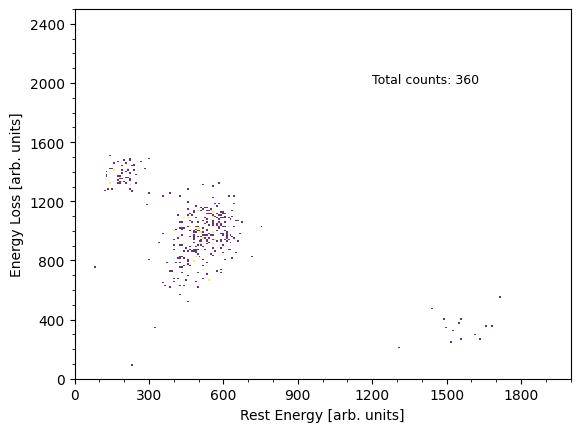

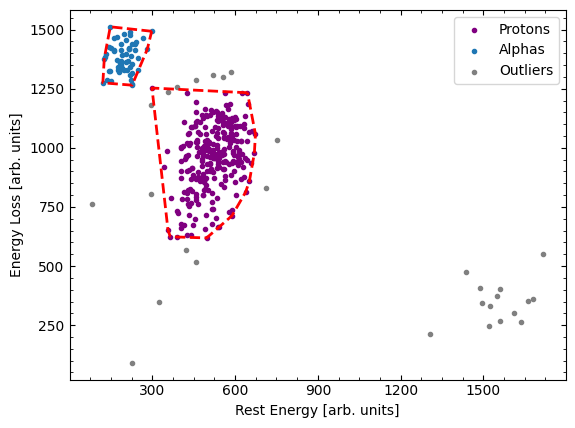

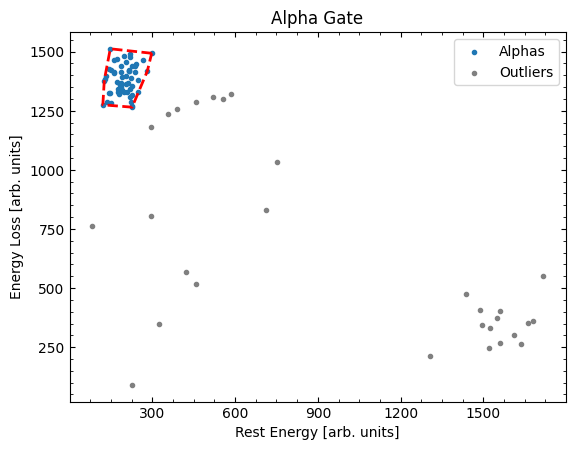

Checking gates with full dataset


In [78]:
path = './data/10kG/'

# start_time = time.time()
x, y, z = PIDClassifier(particle_of_interest= 'Alpha',
              magfield = 10, 
              angle = 35,
              datapath = path, 
              n_subset_samples = 3000,  
              k_NearestNeighbors = 5, 
              prange = [(15, 40),(20, 70)],
              outputpath= './',
              resample = True,
              multfiles = False,
              savefile = False)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"The function took {execution_time:.2f} seconds to run.")

## Running PIDClassifier for all Magnetic Field Settings and Comparing Results

Too small to resample
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 16 
 min_cluster_size: 56
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 2
Assigning particle classes to clusters...
Cluster centroids and labels: 
          Xpos         Ypos Particle Label
0  518.408088   962.988971        Protons
1  195.661017  1381.220339         Alphas
Check the gates and see if they are valid.


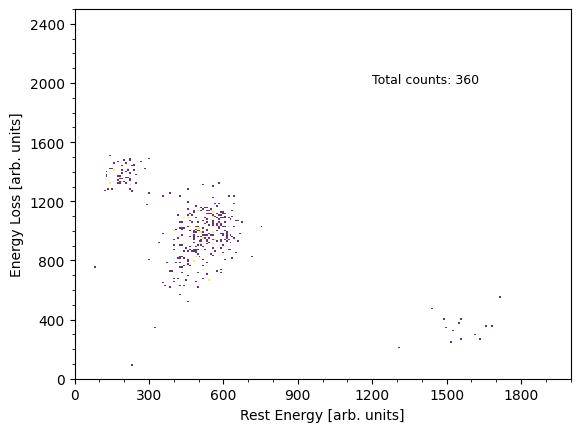

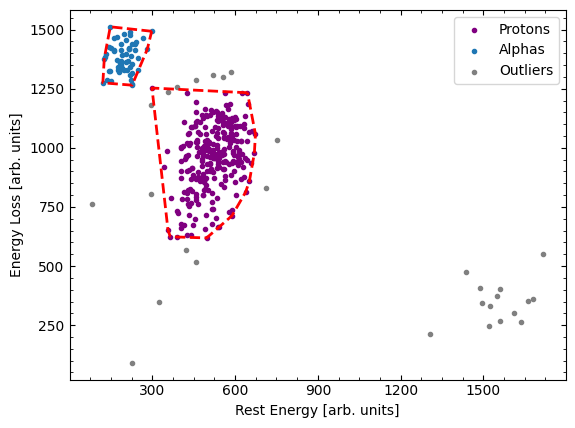

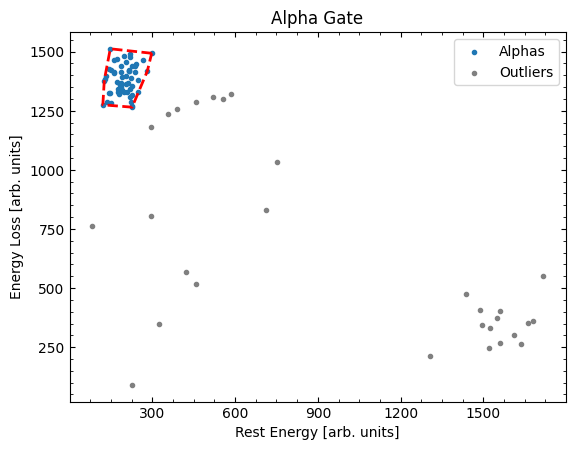

Checking gates with full dataset


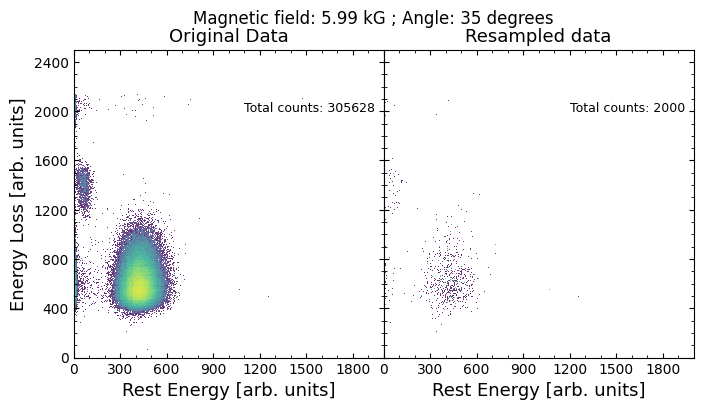

Using the resampled data, check plot if it is admissable.
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 15 
 min_cluster_size: 30
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 3
Assigning particle classes to clusters...
Cluster centroids and labels: 
          Xpos         Ypos Particle Label
0   65.706522  1362.130435         Alphas
1  423.656081   637.624925      Deuterons
2   14.022727   616.356061           None
Check the gates and see if they are valid.


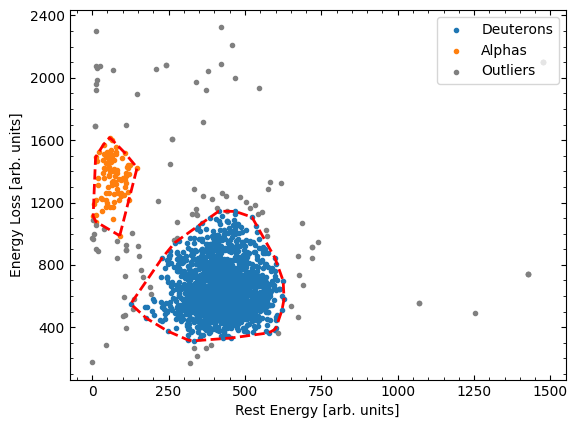

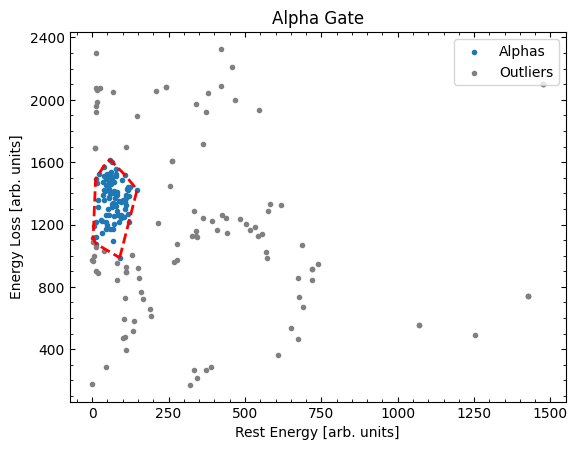

Checking gates with full dataset


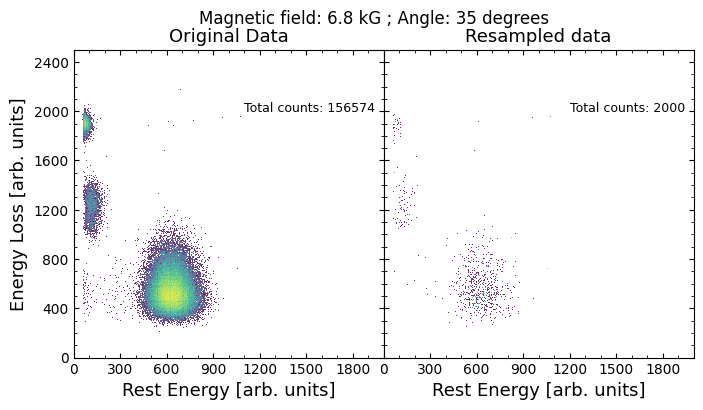

Using the resampled data, check plot if it is admissable.
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 17 
 min_cluster_size: 20
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 3
Assigning particle classes to clusters...
Cluster centroids and labels: 
          Xpos         Ypos Particle Label
0  628.814511   573.029257        Protons
1  129.434783  1253.440994      Deuterons
2   89.505618  1891.157303         Alphas
Check the gates and see if they are valid.


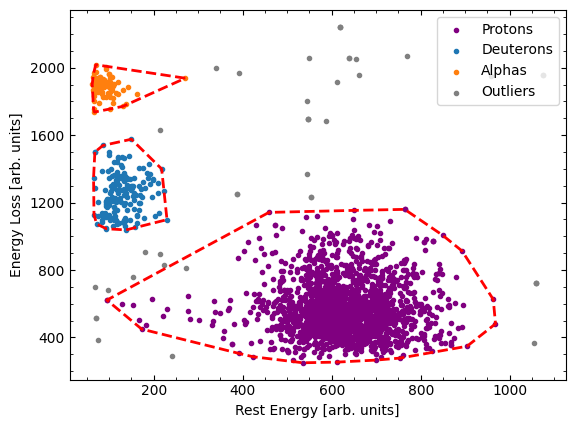

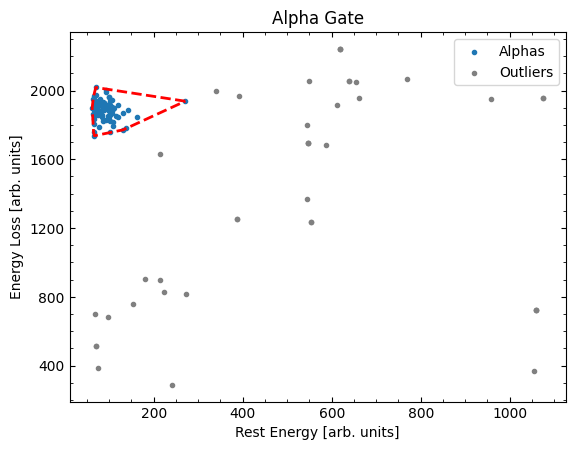

Checking gates with full dataset


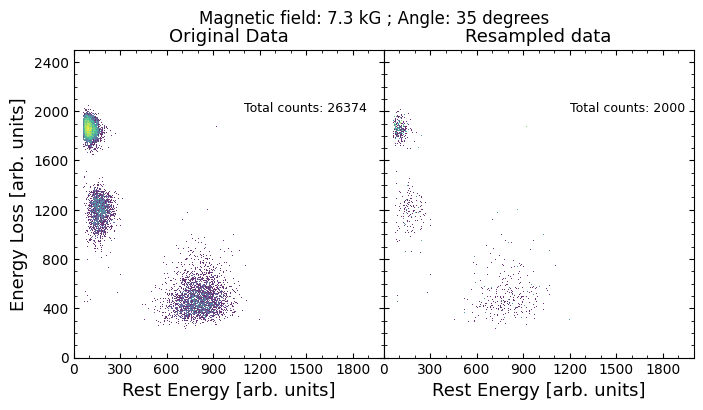

Using the resampled data, check plot if it is admissable.
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 15 
 min_cluster_size: 20
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 3
Assigning particle classes to clusters...
Cluster centroids and labels: 
          Xpos         Ypos Particle Label
0  793.389027   513.269327        Protons
1  170.652174  1174.149758      Deuterons
2  107.582011  1854.481481         Alphas
Check the gates and see if they are valid.


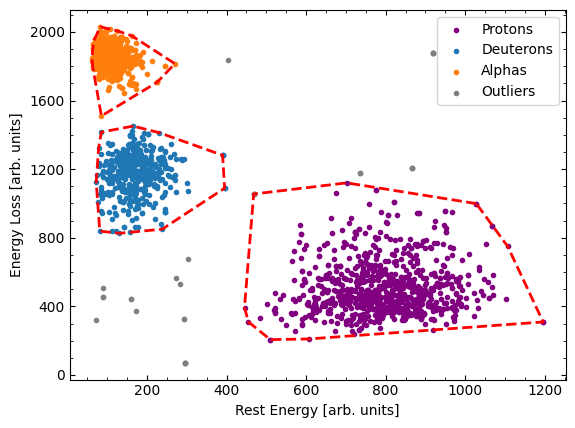

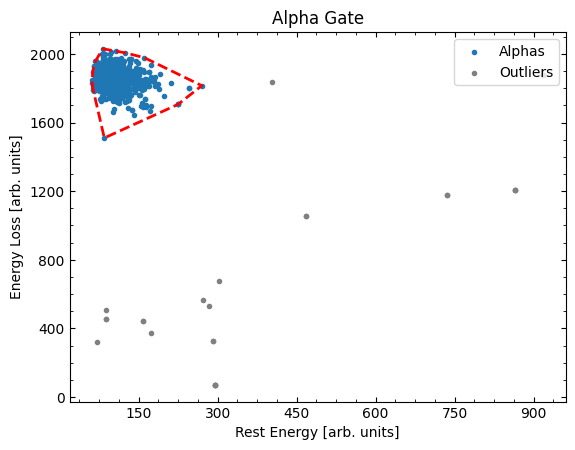

Checking gates with full dataset


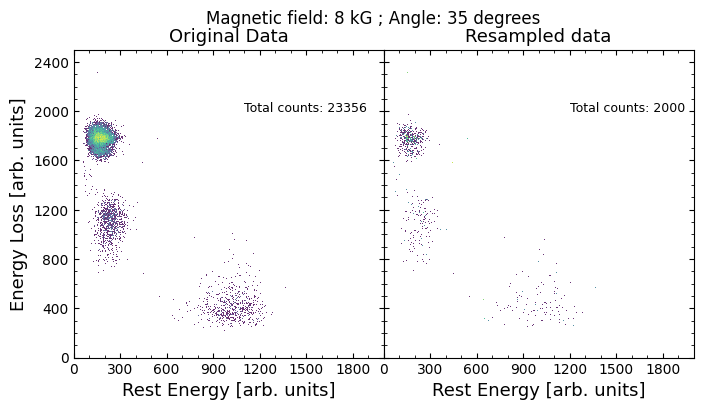

Using the resampled data, check plot if it is admissable.
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 15 
 min_cluster_size: 23
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 3
Assigning particle classes to clusters...
Cluster centroids and labels: 
          Xpos         Ypos Particle Label
0  995.088000   475.410667        Protons
1  174.632146  1771.106877         Alphas
2  230.812169  1082.621693      Deuterons
Check the gates and see if they are valid.


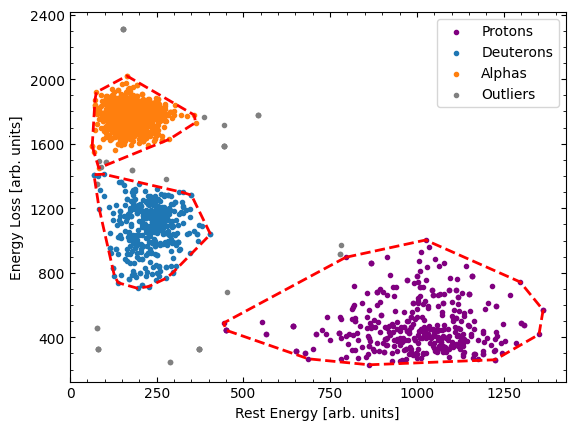

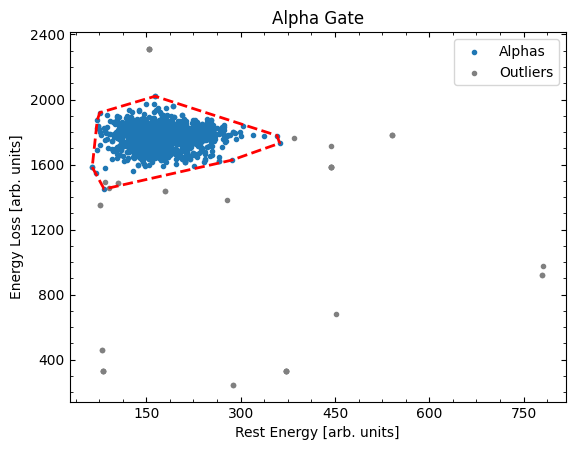

Checking gates with full dataset


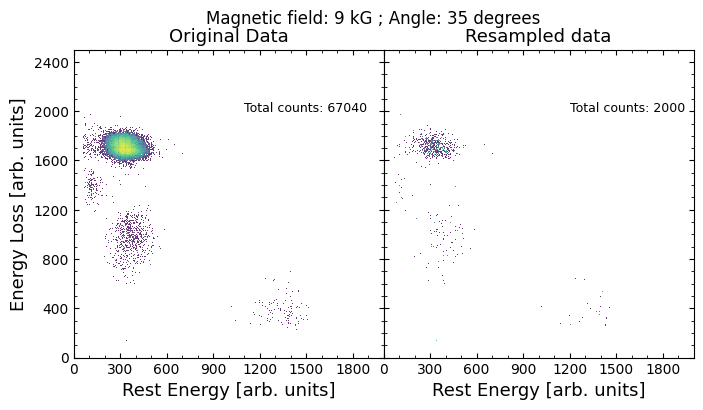

Using the resampled data, check plot if it is admissable.
Optimizing hyperparameters for HDBSCAN...
Optimization complete! 
 Best parameters for HDBSCAN: 
 min_samples: 15 
 min_cluster_size: 24
Performing HDBSCAN clustering algorithm...
HDBSCAN algorithm complete!
Number of Clusters: 4
Assigning particle classes to clusters...
Cluster centroids and labels: 
           Xpos         Ypos Particle Label
0  1303.921053   433.184211        Protons
1   372.463158   957.757895      Deuterons
2   325.185278  1711.995633         Alphas
3   117.615385  1370.923077        Tritons
Check the gates and see if they are valid.


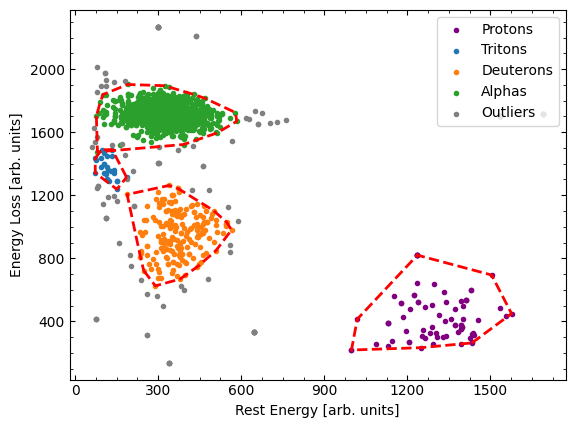

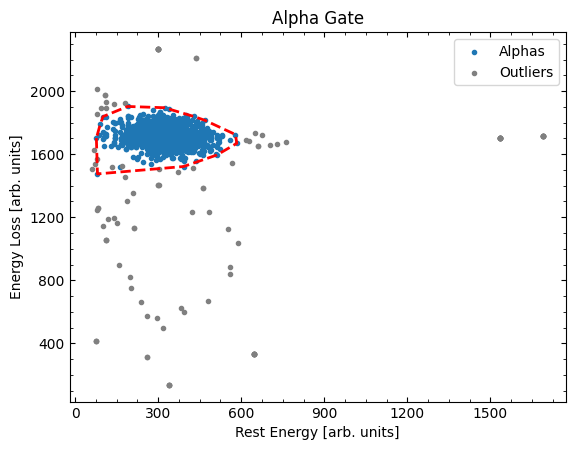

Checking gates with full dataset


In [114]:
path = './data/'
pathlist = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

magfield = [10, 5.99, 6.8, 7.3, 8, 9]
cols = 2  # Number of columns in the subplot grid
rows = 3  # Calculate rows needed

    
# fig, axes = plt.subplots(6,1, figsize=(10,9))
# fig.suptitle('Algorithm Performance with Varying Magnetic Field Settings')
# axes = axes.flatten()  # Flatten in case of extra empty axes
# X = "ScintLeft"; Y = "AnodeBack"
# SL_min = 0; SL_max = 2000
# AB_min = 0 ; AB_max = 4000 

fieldsettings = []
for k in range(len(pathlist)):
    fieldsettings.append(PIDClassifier(particle_of_interest= 'Alpha',
              magfield = magfield[k], 
              angle = 35,
              datapath = pathlist[k], 
              n_subset_samples = 2000,  
              k_NearestNeighbors = 5, 
              prange = [(15, 40),(20, 70)],
              outputpath= './',
              resample = True,
              multfiles = False,
              savefile = False));
   
    


# plt.legend()

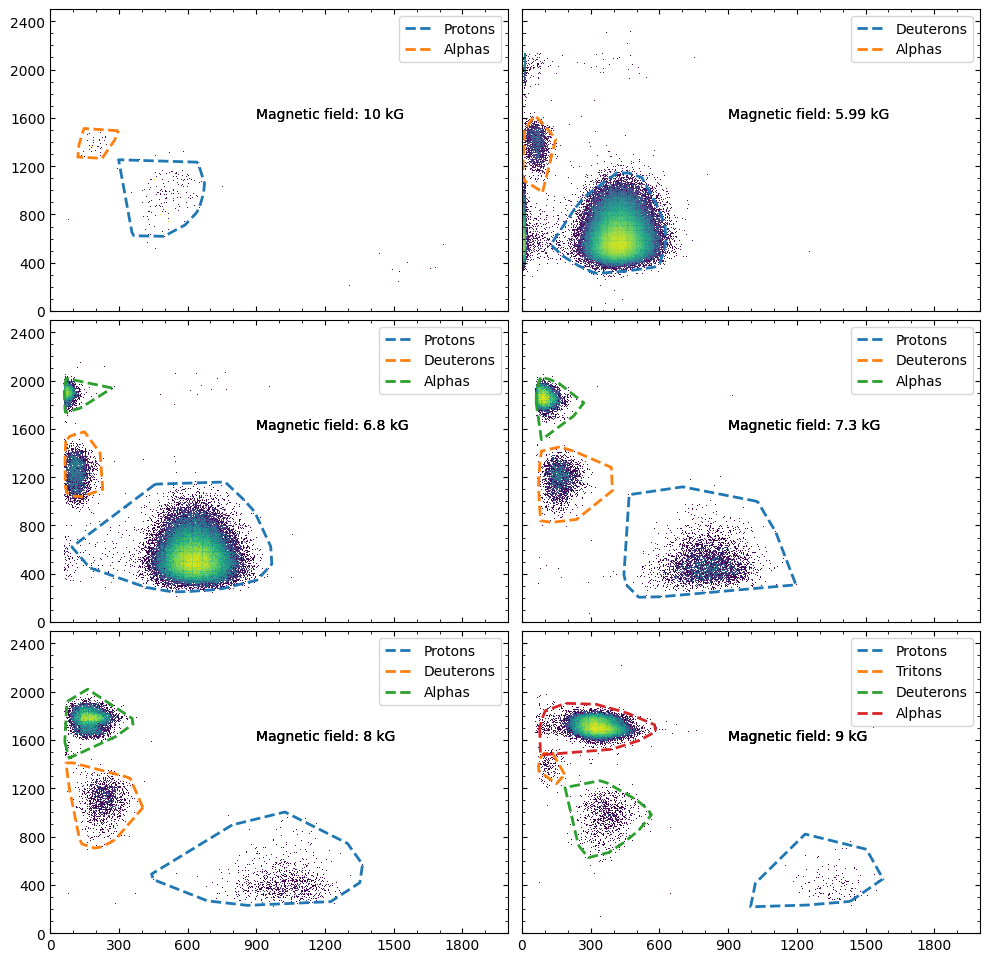

In [115]:
fig, axes = plt.subplots(3,2, figsize=(12,12), sharex = True, sharey = True)
# fig.suptitle('Algorithm Performance with Varying Magnetic Field Settings')
axes = axes.flatten()  # Flatten in case of extra empty axes
magfield = [10, 5.99, 6.8, 7.3, 8, 9]
for k in range(len(fieldsettings)):
    ax = axes[k]
    x, y, z = fieldsettings[k]
    # print(len(z))
    for i in range(len(z)):
        ax.hist2d(x['ScintLeft'], x['AnodeBack'], bins = [512,512], 
                  range = [[0,2000],[0,2500]], cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
        # ax.scatter(x[i]['ScintLeft'], x[i]['AnodeBack'], marker = '.', label = y[i])
        ax.plot(z[i][1]['ScintLeft'], z[i][1]['AnodeBack'],'--', lw=2, label = y[i])

        ax.annotate(f'Magnetic field: {magfield[k]} kG', xy = [900,1600])
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax.xaxis.set_minor_locator(ticker.MaxNLocator(20))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 7))
        ax.yaxis.set_minor_locator(ticker.MaxNLocator(30))
        ax.tick_params(direction = 'in', which = 'both', top =True, right = True)
        ax.legend(loc = 'best')
plt.subplots_adjust(wspace = 0.03, hspace = 0.03)
plt.savefig('AllfieldGates.png')
        

## Trying EMCEE approach to find optimal eps and min_samples inputs

In [24]:
# Define likelihood function
from sklearn.metrics import pairwise_distances
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist

def custom_density_metric(data, labels, cluster_stabilities):
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]  # Ignore noise (-1)
    if len(unique_labels) < 2:  # Too few clusters to evaluate
        return np.inf

    # Calculate cluster centroids
    centroids = [data[labels == lbl].mean(axis=0) for lbl in unique_labels]

    # Mean intra-cluster distance
    intra_distances = []
    for lbl in unique_labels:
        cluster_points = data[labels == lbl]
        if len(cluster_points) > 1:
            intra_dist = np.mean(cdist(cluster_points, cluster_points))
            intra_distances.append(intra_dist)
    mean_intra = np.mean(intra_distances)

    # Mean inter-cluster distance
    inter_distances = cdist(centroids, centroids)
    np.fill_diagonal(inter_distances, np.inf)  # Exclude self-distances
    mean_inter = np.mean(inter_distances)

    # Cluster stability index
    mean_stability = np.mean(cluster_stabilities)

    # Final metric
    metric = mean_intra / mean_inter + 1 / mean_stability
    return metric
    
def log_likelihood(params, X):
    # eps, min_samples = params
    # if 0.1 < params[0] < 0.7 and 50 < params[1] < 80:
    #     return -np.inf 
    X_sampled = X #resample(X, replace = False, n_samples = 1000)
    db = HDBSCAN(min_samples = int(params[0]) , min_cluster_size = int(params[1]*params[0])).fit(X_sampled)
    labels = db.labels_
    # penalize degenerate clustering 
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2 or n_clusters > 4 : #too few or too many clusters
        return -np.inf

    # Compute cluster evaluations
    try:
        # DB = davies_bouldin_score(X_sampled, labels) # minimize
        # CH = calinski_harabasz_score(X, labels) # maximize
        # CDM = custom_density_metric(X,labels,db.probabilities_)
        # std = np.std([DB,CH*1e-4])
        # print(DB)
        # np.mean(db.probabilities_)
        return np.mean(db.probabilities_)
        
    except ValueError:
        return -np.inf

# Define prior
def log_prior(params):
    min_samples, cluster_param = params
    if 10 < min_samples < 15 and 1 < cluster_param < 10:
        return 0.0 # Uniform prior
    return -np.inf # outside bounds

# Define probability
def log_prob(params, X):
    if not np.isfinite(log_prior(params)):
        return -np.inf
    return log_prior(params) + log_likelihood(params, X)

In [25]:
# initial = abs([0.2,70] - np.random.randn(32,2)*[0.2,10]) # initial guess
# for i in range(len(initial)):
#     print(log_likelihood(initial[i],X_sampled))
# len(subsets[0])

In [26]:
# Initialize the emcee 
import emcee

initial = abs([11,6] - np.random.randn(10,2)*[1,2]) # initial guess
n_walkers, n_dim = initial.shape

# scaler = StandardScaler()
# subdata = pd.DataFrame(scaler.fit_transform(subsets[0]), columns = [X,Y])

sampler = emcee.EnsembleSampler(n_walkers,n_dim, log_prob, args = [pd.DataFrame(scaler.fit_transform(subsets[6]), columns = [X,Y])])
sampler.run_mcmc(initial, 500, progress = True)

# # Analyze results
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
best_params = flat_samples[np.argmax(flat_samples[:, 0])]  # Choose based on likelihood

print(f"Best parameters: min_samples ={int(best_params[0])}, min_cluster_scale ={int(best_params[1])}")
print(initial[-1])

100%|██████████| 500/500 [00:41<00:00, 12.13it/s]

Best parameters: min_samples =14, min_cluster_scale =1
[11.32749831  3.11725007]


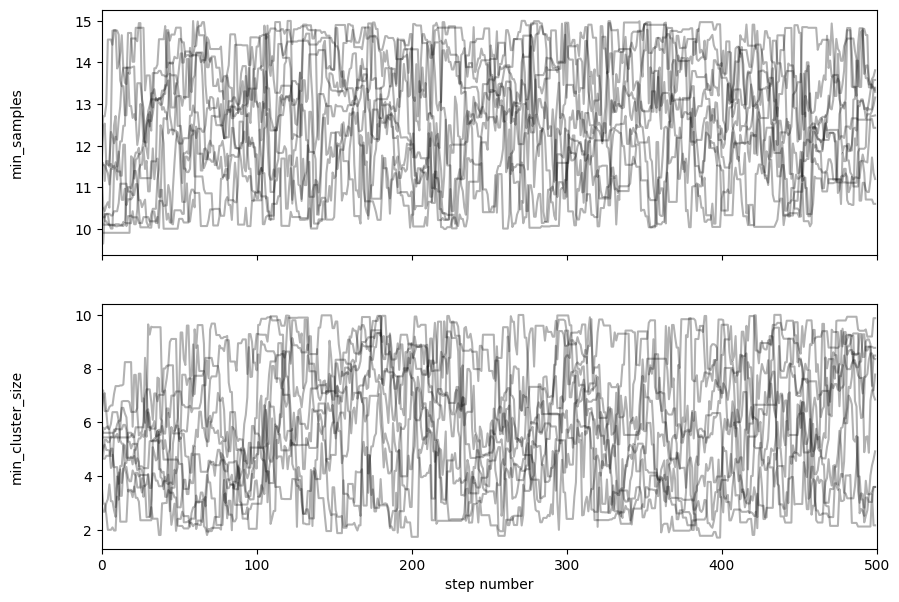

In [27]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['min_samples', 'min_cluster_size']
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# fig, axes = plt.subplots(1, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ['min_samples', 'min_cluster_size']

# ax = axes
# ax.plot(samples[:, :,0], "k", alpha=0.3)
# ax.set_xlim(0, len(samples))
# ax.set_ylabel(labels)
# ax.yaxis.set_label_coords(-0.1, 0.5)

# axes.set_xlabel("step number");

In [155]:
print(initial)

TypeError: only length-1 arrays can be converted to Python scalars

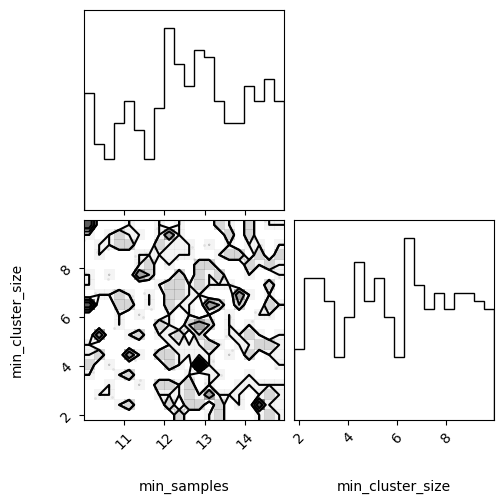

In [28]:
import corner
labels = ['min_samples', 'min_cluster_size']
# f_true = 0.01
# a,b,c,d = param
fig = corner.corner(
    flat_samples, labels=labels
);

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

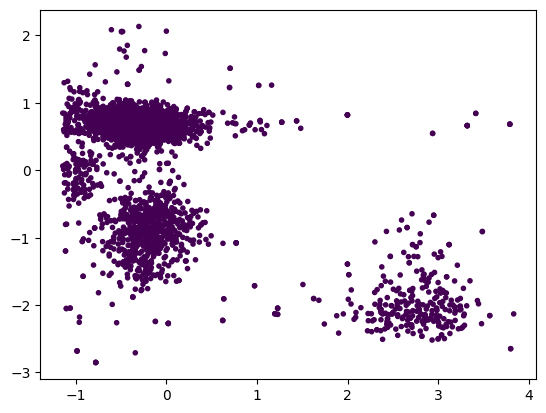

In [46]:
db = DBSCAN(eps=best_params[0], min_samples=int(best_params[1])).fit(X_sampled)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print(n_clusters_)

# Plot result
SLAB = X_sampled
plt.figure()
plt.scatter(SLAB[X], SLAB[Y], marker = '.', c = db.labels_)
# plt.scatter(scaled_data[X], scaled_data[Y], marker = '.', c = db.labels_)

print(davies_bouldin_score(X_sampled, db.labels_)) #maximize
print(calinski_harabasz_score(X_sampled, db.labels_)) # maximize
print('Total:', davies_bouldin_score(X_sampled, db.labels_) + 1e-4*calinski_harabasz_score(X_sampled, db.labels_))

In [31]:
# print('Total:', davies_bouldin_score(X_sampled, db.labels_) + 1e-4*(50000 - calinski_harabasz_score(X_sampled, db.labels_)))
# (max(scaled_data[X])-min(scaled_data[X]))/10

In [ ]:
def normalize_eps(eps, subset_density, full_density):
    return eps * np.sqrt(full_density / subset_density)

def compute_density(data):
    return len(data) / np.prod(np.ptp(data, axis=0))  # Approximate density

# Calculate full dataset density
full_density = compute_density(data)

# Adjust `eps` for each subset
for params, subset in zip(best_params_list, subsets):
    subset_density = compute_density(subset)
    params['eps'] = normalize_eps(params['eps'], subset_density, full_density)